# **Load Dataset**

In [53]:
# add path
import os,sys; 
sys.path.append('./tensor_layers')
sys.path.insert(0, '..')

# Load Dataset
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision import datasets
from torchvision.transforms import ToTensor

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.optim.lr_scheduler import StepLR
from utils import train,test,get_net,Net,OrthoTONN
import math
import time

# Enable this and writer ovject to track metrics during training
from torch.utils.tensorboard import SummaryWriter 

DTYPE = torch.FloatTensor
LONG = torch.LongTensor


# Training parameters
epochs = 10
model_path_dir = './tt_models/'

patience = 10

factor_lr = 0.003
lr = 0.001

r = 8
batch_sz = 64
decay = 0.001
cuda = 1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dtype = torch.float32

complete = True
curr_patience = patience

# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_sz)
test_dataloader = DataLoader(test_data, batch_size=batch_sz)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


# Training Params

## Model Structure Test

In [51]:
import matplotlib.pyplot as plt
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

def get_fashion_mnist_labels(labels):  #@save
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

array([<AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'coat'}>,
       <AxesSubplot:title={'center':'trouser'}>,
       <AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'trouser'}>,
       <AxesSubplot:title={'center':'dress'}>,
       <AxesSubplot:title={'center':'trouser'}>,
       <AxesSubplot:title={'center':'coat'}>,
       <AxesSubplot:title={'center':'dress'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'dress'}>,
       <AxesSubplot:title={'center':'shirt'}>,
       <AxesSubplot:title={'center':'trouser'}>,
       <AxesSubplot:title={'center':'sneaker'}>,
       <AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'bag'}>], dtype=object)

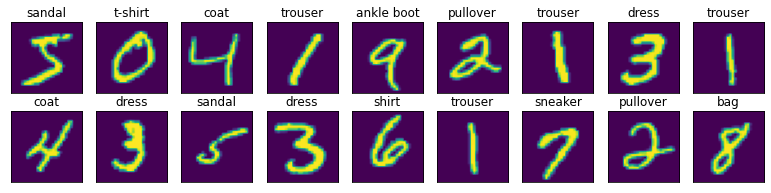

In [52]:
X, y = next(iter(DataLoader(training_data, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y))

In [36]:
def perturb_bernoulli(weight, sigma):
  mask = 0.5*torch.ones_like(weight)
  mask = -sigma*torch.ones_like(weight) + 2*sigma*torch.bernoulli(mask)

  return mask

In [56]:
def perturb_gaussian(weight, sigma, device):
  w_size = weight.size()
  
  return torch.normal(0, sigma, size=w_size).to(device)

In [65]:
#def __init__(self,tensor_type,max_rank,dropouts=0.5,prior_type='log_uniform',device=None,dtype=None):
import math
import copy
pi = torch.tensor(math.pi)
sigma = 0.01
K = 1024
model = Net()

if cuda == 1:
    model = model.cuda()
    DTYPE = torch.cuda.FloatTensor
    LONG = torch.cuda.LongTensor

criterion = nn.CrossEntropyLoss(reduction='sum') 

X, y = next(iter(train_dataloader))
X, y = X.to(device), y.to(device)

with torch.no_grad():
  #f(x+delta_k)
  # copy and compute FP
  g_model=copy.deepcopy(model)
  for m in g_model.modules():
    if isinstance(m, nn.Linear):
      weight = m.weight.data
      print('model', weight[0,0])
      m.delta = perturb_gaussian(weight, sigma, device)
      m.weight = nn.Parameter(weight + m.delta)
      print('x+delta_k',m.weight.data[0,0])
  
  pred_1 = g_model(X)
  loss_1 = criterion(pred_1, y)

  #f(x-delta_k)
  # use the same g_model to copy its m.delta
  for m in g_model.modules():
    if isinstance(m, nn.Linear):
      weight = m.weight.data
      print('model',weight[0,0])
      m.weight = nn.Parameter(weight - 2 * m.delta)
      print('x-delta_k',m.weight.data[0,0])
  
  pred_2 = g_model(X)
  loss_2 = criterion(pred_2, y)

  # ZO-SGD
  for m in g_model.modules():
    if isinstance(m, nn.Linear):
      g = (loss_1-loss_2)/(2*sigma**2) * m.delta;
      print('g=',g)

'''
  Bernoulli perturbtion
'''

# with torch.no_grad():
#   for m in model.modules():
#     if isinstance(m, nn.Linear):
#       weight = m.weight.data
#       print(weight[0,0])
#       m.weight.data = weight + perturb_bernoulli(weight, pi)
#       print(m.weight.data[0,0])

# for param in model.parameters():
#   print(param.size(), param[0,0])

# for param in g_model.parameters():
#   print(param.size(), param[0,0])

model tensor(0.0063, device='cuda:0')
x+delta_k tensor(0.0023, device='cuda:0')
model tensor(0.0058, device='cuda:0')
x+delta_k tensor(0.0157, device='cuda:0')
model tensor(0.0023, device='cuda:0')
x-delta_k tensor(0.0104, device='cuda:0')
model tensor(0.0157, device='cuda:0')
x-delta_k tensor(-0.0041, device='cuda:0')
g= tensor([[ 12.9409,   8.2429,   1.8344,  ..., -73.5226, -17.7757,  15.5100],
        [ 20.9680, -37.7497,  10.9444,  ...,   3.3667,  13.3715,  -5.4686],
        [ -8.9739, -25.4824,   0.5553,  ...,  30.4264,   3.7703, -48.7322],
        ...,
        [-38.0543,  -2.3564,  14.3101,  ...,   7.5946, -27.1699,  -8.5510],
        [ 16.0399,  -4.1015, -24.8274,  ...,   3.0201, -78.4132,  37.1196],
        [ -7.0008,  13.3633, -31.6660,  ...,  21.7960, -46.5239,  55.8660]],
       device='cuda:0')
g= tensor([[-31.8017, -46.9487, -18.9416,  ..., -14.1852,  52.2685,   0.8568],
        [ 15.2402,   7.9471,   8.9956,  ...,  37.1610,  22.6566,  19.9573],
        [-44.3756, -20.9322

'\n  Bernoulli perturbtion\n'

In [63]:
sigma.dtype

AttributeError: 'float' object has no attribute 'dtype'

## ZOO training

In [ ]:
model = Net()
model

In [ ]:
# ZOO optimization method
signature = 'ZOO'
run = 1
model_path = os.path.join(model_path_dir, "model_{}_{}_{}.pt".format(signiture,run))
print("Temp location for models: {}".format(model_path))
os.makedirs(os.path.dirname(model_path), exist_ok=True)
best_valid_acc = 0
best_valid_loss = float('inf')
model = Net()
if cuda == 1:
    model = model.cuda()
    DTYPE = torch.cuda.FloatTensor
    LONG = torch.cuda.LongTensor

# criterion = nn.CrossEntropyLoss(reduction='sum') 
# factors = list(model.parameters())[:3]
# other = list(model.parameters())[3:]
# optimizer = optim.Adam([{"params": factors, "lr": factor_lr}, {"params": other, "lr": lr}], weight_decay=decay)

criterion = nn.CrossEntropyLoss(reduction='sum') 
optimizer = optim.Adam(list(model.parameters()), lr, weight_decay=decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)    # 3

comment = f'run = {run}'
writer = SummaryWriter(comment=comment, log_dir='./tt_runs')

for e in range(epochs):
  # TRAIN
  size = len(train_dataloader.dataset)
  model.train()
  model.zero_grad()
  avg_train_loss = 0.0

  for batch, (X, y) in enumerate(train_dataloader):
    X, y = X.to(device), y.to(device)

    # Compute prediction error
    pred = model(X)
    loss = criterion(pred, y)

In [ ]:
# Open tensorboard
%load_ext tensorboard
%tensorboard --logdir=tt_runs

## Training Loop

In [10]:
signiture = 'MNIST'
output_dim = 10

max_rank = 2
max_rank_list = [2,4,8,10,20]
max_rank_list = [4]
run = 1
# runs = 2

In [13]:
for max_rank in max_rank_list:
#  for run in range(runs):

  model_path = os.path.join(model_path_dir, "model_{}_{}_{}.pt".format(signiture,max_rank,run))
  print("Temp location for models: {}".format(model_path))
  os.makedirs(os.path.dirname(model_path), exist_ok=True)
  best_valid_acc = 0
  best_valid_loss = float('inf')
  model = OrthoTONN(tensor_type='TensorTrainMatrix',max_rank=max_rank,dropouts=0.5,prior_type='log_uniform',eta=1.0, device=device,dtype=dtype)
  if cuda == 1:
      model = model.cuda()
      DTYPE = torch.cuda.FloatTensor
      LONG = torch.cuda.LongTensor

  # criterion = nn.CrossEntropyLoss(reduction='sum') 
  # factors = list(model.parameters())[:3]
  # other = list(model.parameters())[3:]
  # optimizer = optim.Adam([{"params": factors, "lr": factor_lr}, {"params": other, "lr": lr}], weight_decay=decay)

  criterion = nn.CrossEntropyLoss(reduction='sum') 
  optimizer = optim.Adam(list(model.parameters()), lr, weight_decay=decay)
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)    # 3

  comment = f'rank = {max_rank} run = {run}'
  writer = SummaryWriter(comment=comment, log_dir='./tt_runs')

  for e in range(epochs):
    # TRAIN
    size = len(train_dataloader.dataset)
    model.train()
    model.zero_grad()
    avg_train_loss = 0.0

    for batch, (X, y) in enumerate(train_dataloader):
      X, y = X.to(device), y.to(device)

      # Compute prediction error
      pred = model(X)
      loss = criterion(pred, y)

      # Backpropagation
      optimizer.zero_grad()
      loss.backward()
      avg_train_loss += loss.data.item()
      optimizer.step()
    
    # len(training_data) = len(train_dataloader.dataset) -- how many samples
    # len(train_dataloader) -- how many batches
    avg_train_loss = avg_train_loss / len(training_data)  # average over whole training dataset
    print("Epoch {} complete! Average Training loss: {}".format(e, avg_train_loss))
    writer.add_scalar("Avg Train Loss", avg_train_loss, e)

    # Terminate the training process if run into NaN
    if np.isnan(avg_train_loss):
        print("Training got into NaN values...\n\n")
        complete = False
        break
    
    #Valid/Test
    size = len(test_dataloader.dataset)
    num_batches = len(test_dataloader)
    model.eval()
    test_loss, acc_score, f1 = 0, 0, 0
    avg_valid_loss = 0.0
    with torch.no_grad():
      for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        avg_valid_loss += criterion(pred, y).item()
        
        # y itself is true label
        all_true_label = y.cpu().data
        all_predicted_label = pred.argmax(1).cpu().data
        acc_score += accuracy_score(all_true_label, all_predicted_label)
        f1 += f1_score(all_true_label, all_predicted_label, average='weighted')

        # argmax will eliminate this dimension!
        # correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # in every iteration, the loss of the batch is summed up. actual loss should divide dataset size
    avg_valid_loss = avg_valid_loss / len(test_data)  # average over whole validation dataset
    print("Validation loss is: {}".format(avg_valid_loss))
    writer.add_scalar("Avg Valid Loss", avg_valid_loss, e)

    if np.isnan(avg_valid_loss):
      print("Training got into NaN values...\n\n")
      complete = False
      break

    # score is calculated every batch
    acc_score /= num_batches
    f1 /= num_batches

    print("Accuracy score is {}".format(acc_score))
    print("F1-score is {}".format(f1))
    
    if (avg_valid_loss < best_valid_loss):
        curr_patience = patience
        best_valid_loss = avg_valid_loss
        torch.save(model, model_path)
        print("Found new best model, saving to disk...")
    else:
        curr_patience -= 1
    
    if curr_patience <= 0:
        break
        

Temp location for models: ./tt_models/model_MNIST_4_1.pt
Epoch 0 complete! Average Training loss: 0.9904296639283499
Validation loss is: 0.36663719880580903
Accuracy score is 0.8942078025477707
F1-score is 0.8933782245865438
Found new best model, saving to disk...
Epoch 1 complete! Average Training loss: 0.534040156976382
Validation loss is: 0.2880606528520584
Accuracy score is 0.916202229299363
F1-score is 0.9154574772541343
Found new best model, saving to disk...
Epoch 2 complete! Average Training loss: 0.4508840109586716
Validation loss is: 0.24896067473888397
Accuracy score is 0.9270501592356688
F1-score is 0.9262492608723443
Found new best model, saving to disk...
Epoch 3 complete! Average Training loss: 0.40093127624193825
Validation loss is: 0.2261153151035309
Accuracy score is 0.9336186305732485
F1-score is 0.9330336514699196
Found new best model, saving to disk...
Epoch 4 complete! Average Training loss: 0.3636346802512805
Validation loss is: 0.20610321423113345
Accuracy score

In [ ]:
X = torch.reshape(X,[64,1,28,28])
model.eval()
X, y = X.to(device), y.to(device)
pred = model(X)
pred.size(), y.size()

In [ ]:
all_true_label = y.cpu().data
all_predicted_label = pred.argmax(1).cpu().data
print("all_true_label is: {}".format(all_true_label))
print("all_predicted_label is: {}".format(all_predicted_label))

In [ ]:
pred.argmax(1).cpu().data.size()

## QR decomp

In [3]:
max_rank = 2
run = 1
model_path = os.path.join(model_path_dir, "model_{}_{}_{}.pt".format(signiture,max_rank,run))
best_model = torch.load(model_path)
best_model.eval()
best_model.to('cpu')

NameError: name 'os' is not defined

In [ ]:
best_model.fc1.tensor.trainable_variables[2].data.size()

torch.Size([2, 7, 8, 2])

In [ ]:
order = best_model.fc1.tensor.order
ortho_cores = []

for i_order in range(order-1,-1,-1):

  tt_core = best_model.fc1.tensor.trainable_variables[i_order].data
  size = tt_core.size()
  tt_matrix = torch.reshape(tt_core, (size[0]*size[1], size[2]*size[3]))
  if i_order != order-1:
    tt_core = torch.matmul(tt_matrix, L)
  
  tt_matrix = torch.transpose(tt_matrix,0,1)
  QT, R = torch.linalg.qr(tt_matrix, mode="complete")
  L = torch.transpose(R,0,1)
  Q = torch.transpose(Q,0,1)
  ortho_cores.insert(0,Q)

U, S, Vh = torch.linalg.svd(L)
ortho_cores.insert(0,Vh)
ortho_cores.insert(0,U)

RuntimeError: ignored

In [ ]:
print(tt_matrix.size())
print(Q)
print(R)

torch.Size([8, 4])
tensor([[-0.4715,  0.1050,  0.1914, -0.3383,  0.0488,  0.5277, -0.5783,  0.0174],
        [-0.2078, -0.1173,  0.4082,  0.5203,  0.2509, -0.4624, -0.4283, -0.2135],
        [-0.0342,  0.0886, -0.3271, -0.5492,  0.2030, -0.6334, -0.2971,  0.2273],
        [-0.1245,  0.2322,  0.6431, -0.4141, -0.3474, -0.2737,  0.3126, -0.2286]])
tensor([[-0.6149, -0.4502, -0.5039, -0.5871],
        [ 0.0000,  0.1646,  0.1201,  0.2936],
        [ 0.0000,  0.0000, -0.0480, -0.0273],
        [ 0.0000,  0.0000,  0.0000, -0.1658]])


In [ ]:
from .interferometer import interferometer as itf 
Q = ortho_cores[-1]
I = itf.square_decomposition(Q)
I.draw()

3
2
1
0


## SVD

In [11]:
max_rank = 2
run = 1
model_path = os.path.join(model_path_dir, "model_{}_{}_{}.pt".format(signiture,max_rank,run))
best_model = torch.load(model_path)
best_model.eval()
best_model.to('cpu')

OrthoTONN(
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): TensorizedLinear(
    in_features=784, out_features=1024, bias=False
    (tensor): TensorTrainMatrix(
      (trainable_variables): ParameterList(
          (0): Parameter containing: [torch.FloatTensor of size 1x4x4x2]
          (1): Parameter containing: [torch.FloatTensor of size 2x7x8x2]
          (2): Parameter containing: [torch.FloatTensor of size 2x7x8x2]
          (3): Parameter containing: [torch.FloatTensor of size 2x4x4x1]
          (4): Parameter containing: [torch.FloatTensor of size 1x4x4x2]
          (5): Parameter containing: [torch.FloatTensor of size 2x7x8x2]
          (6): Parameter containing: [torch.FloatTensor of size 2x7x8x2]
          (7): Parameter containing: [torch.FloatTensor of size 2x4x4x1]
          (8): Parameter containing: [torch.FloatTensor of size 2]
          (9): Parameter containing: [torch.FloatTensor of size 2]
          (10): Parameter containing: [torch.FloatTensor of size 2]
     

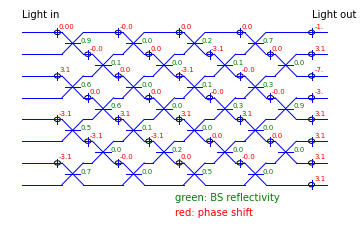

In [23]:
import interferometer as itf

tt_core = best_model.fc1.tensor.trainable_variables[3].data
size = tt_core.size()
tt_matrix = torch.reshape(tt_core, (size[0]*size[1], size[2]*size[3]))

U, S, Vh = torch.linalg.svd(tt_matrix)
# inf requires numpy array
U = U.numpy()
I = itf.square_decomposition(U)
I.draw()

In [42]:
U = tt_matrix.numpy()
U2 = np.power(U,2)
U2_row = np.sum(U2,axis=0)
U2_col = np.sum(U2,axis=1)

In [44]:
U2_row

array([1.6180354, 1.0419817, 1.0265269, 2.5757833], dtype=float32)

## Eval best model

In [ ]:
def eval_at_model_path(model_path, test_iterator):
  best_model = torch.load(model_path)
  best_model.eval()
  best_model.to(device)

  #Valid/Test
  size = len(test_iterator.dataset)
  num_batches = len(test_iterator)
  test_loss, acc_score, f1 = 0, 0, 0
  avg_valid_loss = 0.0
  with torch.no_grad():
    for X, y in test_iterator:
      X, y = X.to(device), y.to(device)
      pred = best_model(X)
      
      # y itself is true label
      all_true_label = y.cpu().data
      all_predicted_label = pred.argmax(1).cpu().data
      acc_score += accuracy_score(all_true_label, all_predicted_label)
      f1 += f1_score(all_true_label, all_predicted_label, average='weighted')

  # score is calculated every batch
  acc_score /= num_batches
  f1 /= num_batches
  print("Accuracy score is {}".format(acc_score))
  print("F1-score is {}".format(f1))

  return acc_score

In [ ]:
best_model_path = 0
best_acc = 0
for max_rank in max_rank_list:
#  for run in range(runs):
  model_path = os.path.join(model_path_dir, "model_{}_{}_{}.pt".format(signiture,max_rank,run))
  print(model_path)
  acc = eval_at_model_path(model_path, test_dataloader)
  print("-------------")
  if acc > best_acc:
      best_acc = acc
      best_model_path = model_path

./tt_models/model_MNIST_2_1.pt
Accuracy score is 0.9357085987261147
F1-score is 0.9351699481399507
-------------
./tt_models/model_MNIST_4_1.pt
Accuracy score is 0.962281050955414
F1-score is 0.9619681106624476
-------------
./tt_models/model_MNIST_8_1.pt
Accuracy score is 0.9735270700636943
F1-score is 0.9733664613900941
-------------
